# Time series forecasting with DeepAR

## ***This is using the hourly aggregated data across VMs***
DeepAR is a supervised learning algorithm for forecasting scalar time series. 


Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [48]:
bucket = 'sagemaker-testtimeseries'
prefix = 'sagemaker/test-demo-deepar'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
role

'arn:aws:iam::945416147148:role/service-role/AmazonSageMaker-ExecutionRole-20180616T095406'

Now we'll import the Python libraries we'll need.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import glob
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer
import boto3
import  s3fs
import  sagemaker
from sagemaker import get_execution_role

In [4]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [5]:

containers  = {
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]

In [6]:
role

'arn:aws:iam::945416147148:role/service-role/AmazonSageMaker-ExecutionRole-20180616T095406'

---
## Data

Let's download the data.  More information about this dataset can be found [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [7]:
#!wget http://gwa.ewi.tudelft.nl/fileadmin/pds/trace-archives/grid-workloads-archive/datasets/gwa-t-12/rnd.zip

In [8]:
#import zipfile
#with zipfile.ZipFile("rnd.zip","r") as zip_ref:
#    zip_ref.extractall("targetdir")

And take a look at it.

In [9]:
all_files = glob.glob(os.path.join('targetdir/rnd/2013-7/', "1*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_df   = pd.concat(df_from_each_file)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [10]:
all_files = glob.glob(os.path.join('targetdir/rnd/2013-8/', "1*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_df8   = pd.concat(df_from_each_file)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [11]:
all_files = glob.glob(os.path.join('targetdir/rnd/2013-9/', "1*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_df9   = pd.concat(df_from_each_file)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [12]:
newdat = concatenated_df.append(concatenated_df8)
newerdat = newdat.append(concatenated_df9)
concatenated_df = newerdat

In [13]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2692928 entries, 0 to 11506
Data columns (total 11 columns):
Timestamp [ms]                           int64
CPU cores                                int64
CPU capacity provisioned [MHZ]           float64
CPU usage [MHZ]                          float64
CPU usage [%]                            float64
Memory capacity provisioned [KB]         float64
Memory usage [KB]                        float64
Disk read throughput [KB/s]              float64
Disk write throughput [KB/s]             float64
Network received throughput [KB/s]       float64
Network transmitted throughput [KB/s]    float64
dtypes: float64(9), int64(2)
memory usage: 246.5 MB


In [14]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
#concatenated_df.apply(pd.to_numeric, errors='ignore')
concatenated_df.describe()
concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek


concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
# Feature engineering with the date
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)
concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]

concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]

hourlydat = concatenated_df.resample('H').sum()

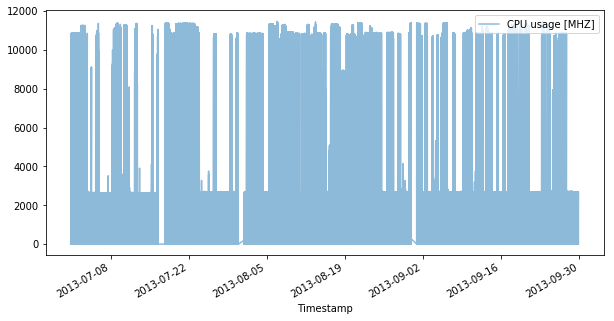

In [15]:
cpu = concatenated_df[['CPU usage [MHZ]']]
cpu.plot(alpha=0.5, style='-', figsize=(10, 5))
plt.legend(loc='upper right');
#cpu.resample('H').sum().plot(style=':', figsize=(10, 5))
#cpu.asfreq('H').plot(style='--');
plt.legend(loc='upper right');

In [16]:
hourlydat["start"] = hourlydat.index
hourlydat['target'] = hourlydat['CPU usage [MHZ]']
jsondat=pd.DataFrame(hourlydat['start'])
jsondat['start'] = hourlydat.index
result = pd.concat([hourlydat['start'], hourlydat['target']], axis=1)
result = result.reset_index()
result.drop('Timestamp', axis=1, inplace=True)
#result.start = result.start.astype(str)
#result.set_index('start',inplace=True)
#result

In [17]:
result.set_index('start',inplace=True)
result.index = pd.to_datetime(result.index) 

In [18]:
# remove two july days for even dataset
result = result[2:]

In [19]:
start = result.index.min()
end = result.index.max()
index = pd.date_range(start, end, freq='D')
index = index.map(lambda t: t.strftime('%Y-%m-%d'))
makingjson = pd.DataFrame(index=index, columns=['target'])
makingjson.index.name = 'date'

for day in index:
    makingjson.loc[day, 'target'] = result.loc[day, 'target'].tolist()


In [20]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [21]:
makingjson = makingjson.reset_index(drop=False)


In [22]:
makingjson.columns = ['start', 'target']

In [23]:
makingjson.head()

,start,target
0,2013-07-01,"[574199.4713140074, 504223.53358262416, 602037..."
1,2013-07-02,"[650204.8214047799, 653213.9708218395, 565570...."
2,2013-07-03,"[992436.0216913229, 952792.0524644597, 924735...."
3,2013-07-04,"[221054.54960393056, 231642.20276966706, 22931..."
4,2013-07-05,"[133744.91281717448, 137004.83592266572, 13975..."


In [24]:
len(makingjson)*.2

18.2

In [25]:
traindat = makingjson[:-round(len(makingjson)*.2)]

In [26]:
#makingjson.to_json('test.json', orient='records', lines=True)


In [27]:
#traindat.to_json('train.json', orient='records', lines=True)


In [28]:
t0  = '2013-07-01 00:00:00'
data_length = 2182
num_ts = 90
period = 24
freq= "H"

In [29]:
index = pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
index
data = result['target']
index

DatetimeIndex(['2013-07-01 00:00:00', '2013-07-01 01:00:00',
               '2013-07-01 02:00:00', '2013-07-01 03:00:00',
               '2013-07-01 04:00:00', '2013-07-01 05:00:00',
               '2013-07-01 06:00:00', '2013-07-01 07:00:00',
               '2013-07-01 08:00:00', '2013-07-01 09:00:00',
               ...
               '2013-09-29 12:00:00', '2013-09-29 13:00:00',
               '2013-09-29 14:00:00', '2013-09-29 15:00:00',
               '2013-09-29 16:00:00', '2013-09-29 17:00:00',
               '2013-09-29 18:00:00', '2013-09-29 19:00:00',
               '2013-09-29 20:00:00', '2013-09-29 21:00:00'],
              dtype='datetime64[ns]', length=2182, freq='H')

In [30]:
freq = 'H'
prediction_length = 48
context_length = 24

In [31]:
time_series = []
time_series.append(pd.Series(data=data, index=index))

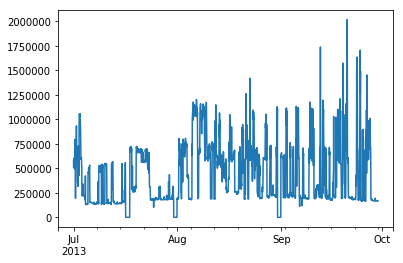

In [32]:
time_series[0].plot()
plt.show()

In [33]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

In [34]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))


In [35]:
with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

In [36]:
s3_data_path

'sagemaker-testtimeseries/sagemaker/test-demo-deepar/data'

In [37]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='test-demo-deepar',
    output_path="s3://" + s3_output_path
)

In [49]:
# student t under estimates with these parameters
hyperparameters  = {
    "time_freq": freq,
    "context_length": context_length,
    "prediction_length": prediction_length,
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "student-t",
    "epochs": "50",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [50]:
estimator.set_hyperparameters(**hyperparameters)

In [51]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: test-demo-deepar-2018-06-19-21-00-53-953


.........................
Arguments: train
[06/19/2018 21:04:52 INFO 140583306606400] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'dropout_rate': u'0.10', u'cardinality': u'', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'mini_batch_size': u'32', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[06/19/2018 21:04:52 INFO 140583306606400] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.001', u'num_cells': u'40', u'prediction_length': u'48', u'epochs': u'50', u'time_freq': u'H', u'context_length': u'24', u'num_layers': u'3', u'mini_batch_size': u'32', u'likelihood': u'student-t', u'early_stopping_patience': 

[06/19/2018 21:05:03 INFO 140583306606400] Epoch[9] Batch[5] avg_epoch_loss=13.484985
[06/19/2018 21:05:03 INFO 140583306606400] Epoch[9] Batch [5]#011Speed: 318.28 samples/sec#011loss=13.484985
[06/19/2018 21:05:03 INFO 140583306606400] processed a total of 303 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 939.3298625946045, "sum": 939.3298625946045, "min": 939.3298625946045}}, "EndTime": 1529442303.894599, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529442302.940193}

[06/19/2018 21:05:03 INFO 140583306606400] #throughput_metric: host=algo-1, train throughput=322.513006352 records/second
[06/19/2018 21:05:03 INFO 140583306606400] #progress_metric: host=algo-1, completed 20 % of epochs
[06/19/2018 21:05:03 INFO 140583306606400] best epoch loss so far
[06/19/2018 21:05:03 INFO 140583306606400] Saved checkpoint to "/opt/ml/model/state_8ad1f0ed-bec3-4c8f-be56-b2f2c2a58510-0000.params"
#metrics {"Metrics": {"state

[06/19/2018 21:05:13 INFO 140583306606400] Epoch[19] Batch[5] avg_epoch_loss=12.764702
[06/19/2018 21:05:13 INFO 140583306606400] Epoch[19] Batch [5]#011Speed: 337.90 samples/sec#011loss=12.764702
[06/19/2018 21:05:14 INFO 140583306606400] processed a total of 304 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 908.4780216217041, "sum": 908.4780216217041, "min": 908.4780216217041}}, "EndTime": 1529442314.011022, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529442313.089304}

[06/19/2018 21:05:14 INFO 140583306606400] #throughput_metric: host=algo-1, train throughput=334.57405524 records/second
[06/19/2018 21:05:14 INFO 140583306606400] #progress_metric: host=algo-1, completed 40 % of epochs
[06/19/2018 21:05:14 INFO 140583306606400] best epoch loss so far
[06/19/2018 21:05:14 INFO 140583306606400] Saved checkpoint to "/opt/ml/model/state_8b57f884-0b89-4d14-881f-13644ad8634f-0000.params"
#metrics {"Metrics": {"stat

[06/19/2018 21:05:23 INFO 140583306606400] Epoch[28] Batch[10] avg_epoch_loss=12.572952
[06/19/2018 21:05:23 INFO 140583306606400] Epoch[28] Batch [10]#011Speed: 316.87 samples/sec#011loss=12.479017
[06/19/2018 21:05:23 INFO 140583306606400] processed a total of 346 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1061.427116394043, "sum": 1061.427116394043, "min": 1061.427116394043}}, "EndTime": 1529442323.366801, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529442322.289391}

[06/19/2018 21:05:23 INFO 140583306606400] #throughput_metric: host=algo-1, train throughput=325.942469346 records/second
[06/19/2018 21:05:23 INFO 140583306606400] #progress_metric: host=algo-1, completed 58 % of epochs
[06/19/2018 21:05:23 INFO 140583306606400] best epoch loss so far
[06/19/2018 21:05:23 INFO 140583306606400] Saved checkpoint to "/opt/ml/model/state_424e9247-81b9-4fda-966d-9afc1e17e882-0000.params"
#metrics {"Metrics": {"s

[06/19/2018 21:05:33 INFO 140583306606400] Epoch[38] Batch[10] avg_epoch_loss=12.537939
[06/19/2018 21:05:33 INFO 140583306606400] Epoch[38] Batch [10]#011Speed: 338.56 samples/sec#011loss=12.543863
[06/19/2018 21:05:33 INFO 140583306606400] processed a total of 335 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1030.5919647216797, "sum": 1030.5919647216797, "min": 1030.5919647216797}}, "EndTime": 1529442333.637148, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529442332.593777}

[06/19/2018 21:05:33 INFO 140583306606400] #throughput_metric: host=algo-1, train throughput=325.03191466 records/second
[06/19/2018 21:05:33 INFO 140583306606400] #progress_metric: host=algo-1, completed 78 % of epochs
[06/19/2018 21:05:33 INFO 140583306606400] loss did not improve for 1 epochs
[06/19/2018 21:05:33 INFO 140583306606400] Epoch[39] Batch[0] avg_epoch_loss=12.533126
[06/19/2018 21:05:34 INFO 140583306606400] Epoch[39] Batch

[06/19/2018 21:05:43 INFO 140583306606400] Epoch[48] Batch[10] avg_epoch_loss=12.512419
[06/19/2018 21:05:43 INFO 140583306606400] Epoch[48] Batch [10]#011Speed: 373.84 samples/sec#011loss=12.616984
[06/19/2018 21:05:43 INFO 140583306606400] processed a total of 325 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 984.5750331878662, "sum": 984.5750331878662, "min": 984.5750331878662}}, "EndTime": 1529442343.568735, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529442342.571965}

[06/19/2018 21:05:43 INFO 140583306606400] #throughput_metric: host=algo-1, train throughput=330.057125369 records/second
[06/19/2018 21:05:43 INFO 140583306606400] #progress_metric: host=algo-1, completed 98 % of epochs
[06/19/2018 21:05:43 INFO 140583306606400] loss did not improve for 1 epochs
[06/19/2018 21:05:43 INFO 140583306606400] Epoch[49] Batch[0] avg_epoch_loss=12.223332
[06/19/2018 21:05:44 INFO 140583306606400] Epoch[49] Batch[5

Create endpoint and predictor
Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

Note: remember to delete the enpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [52]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: test-demo-deepar-2018-06-19-21-00-53-953
INFO:sagemaker:Creating endpoint-config with name test-demo-deepar-2018-06-19-21-00-53-953
INFO:sagemaker:Creating endpoint with name test-demo-deepar-2018-06-19-21-00-53-953


-----------------------------------------------------------------------------------------!

In [53]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [54]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [55]:
#traindat = pd.Series(traindat)

In [56]:
list_of_df  = predictor.predict(time_series_training)
actual_data = time_series

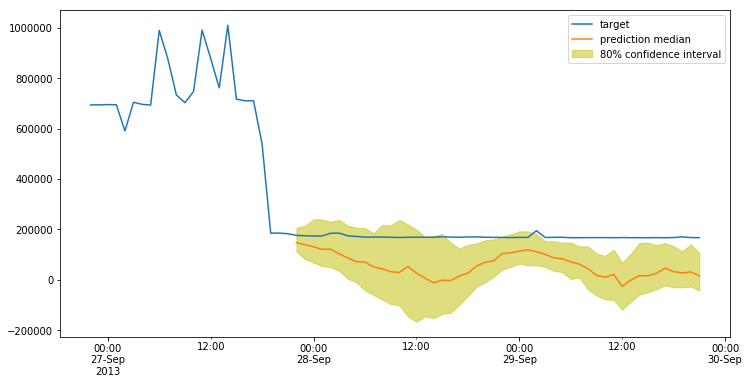

In [57]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

## Created hyperparameter tuning job on the GUI, but attempting to do with code below.

In [ ]:
s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/validation/'.format(bucket, prefix)

In [706]:
tuning_job_config = {
   "HyperParameterTuningJobConfig": { 
      "HyperParameterTuningJobObjective": { 
         "MetricName": "string",
         "Type": "string"
      },
      "ParameterRanges": { 
         "CategoricalParameterRanges": [ 
            { 
               "Name": "string",
               "Values": [ "string" ]
            }
         ],
         "ContinuousParameterRanges": [ 
            { 
               "MaxValue": "string",
               "MinValue": "string",
               "Name": "string"
            }
         ],
         "IntegerParameterRanges": [ 
            { 
               "MaxValue": "string",
               "MinValue": "string",
               "Name": "string"
            }
         ]
      },
      "ResourceLimits": { 
         "MaxNumberOfTrainingJobs": number,
         "MaxParallelTrainingJobs": number
      },
      "Strategy": "string"
   },
   "HyperParameterTuningJobName": "string",
   "Tags": [ 
      { 
         "Key": "string",
         "Value": "string"
      }
   ],
   "TrainingJobDefinition": { 
      "AlgorithmSpecification": { 
         "MetricDefinitions": [ 
            { 
               "Name": "string",
               "Regex": "string"
            }
         ],
         "TrainingImage": "string",
         "TrainingInputMode": "string"
      },
      "InputDataConfig": [ 
         { 
            "ChannelName": "string",
            "CompressionType": "string",
            "ContentType": "string",
            "DataSource": { 
               "S3DataSource": { 
                  "S3DataDistributionType": "string",
                  "S3DataType": "string",
                  "S3Uri": "string"
               }
            },
            "RecordWrapperType": "string"
         }
      ],
      "OutputDataConfig": { 
         "KmsKeyId": "string",
         "S3OutputPath": "string"
      },
      "ResourceConfig": { 
         "InstanceCount": number,
         "InstanceType": "string",
         "VolumeKmsKeyId": "string",
         "VolumeSizeInGB": number
      },
      "RoleArn": "string",
      "StaticHyperParameters": { 
         "string" : "string" 
      },
      "StoppingCondition": { 
         "MaxRuntimeInSeconds": number
      },
      "VpcConfig": { 
         "SecurityGroupIds": [ "string" ],
         "Subnets": [ "string" ]
      }
   }
}

NameError: name 'number' is not defined

In [704]:
smclient = boto3.Session().client('sagemaker')

In [705]:
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                            HyperParameterTuningJobConfig = tuning_job_config,
                                            TrainingJobDefinition = training_job_definition)


NameError: name 'tuning_job_name' is not defined

### Query a trained model by using the model's endpoint. The endpoint takes the following JSON request format.

In [ ]:

{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0], "cat": 0},
  { "start": "2012-01-30", "target": [1.0], "cat": 2 },
  { "start": "1999-01-30", "target": [2.0, 1.0], "cat": 1 }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["mean", "quantiles", "samples"],
  "quantiles": ["0.5", "0.9"]
 }
}

In [128]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: test-demo-deepar-2018-06-19-17-29-48-394
